In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

In [3]:
# Cargar el archivo CSV (sustituye 'ruta/del/archivo.csv' por la ruta real de tu archivo)
df = pd.read_csv('Dataset.csv')

In [5]:
# Carga y limpieza del dataframe
df = pd.read_csv('Dataset.csv')
df = df[["Age at Diagnosis", "Mutation Count", "Gender", "Race",
         "Overall Survival (Months)", "Overall Survival Status"]].copy()

# Eliminar filas con NaN
df = df.dropna()

# Codificación categórica
df = pd.get_dummies(df, columns=["Gender", "Race"], drop_first=True)

# Definir X, time, event
X = df.drop(columns=["Overall Survival (Months)", "Overall Survival Status"])
time = df["Overall Survival (Months)"].values
event = df["Overall Survival Status"].values

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train_time, y_test_time, y_train_event, y_test_event = train_test_split(
    X_scaled, time, event, test_size=0.2, random_state=42
)

# Dataset personalizado
class SurvivalDataset(Dataset):
    def __init__(self, x, time, event):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.time = torch.tensor(time, dtype=torch.float32)
        self.event = torch.tensor(event, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.time[idx], self.event[idx]

train_dataset = SurvivalDataset(X_train, y_train_time, y_train_event)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Modelo DeepSurv
class DeepSurvModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Cox PH loss
def cox_ph_loss(risk, time, event):
    order = torch.argsort(time, descending=True)
    risk = risk[order]
    event = event[order]

    log_cumsum_exp = torch.logcumsumexp(risk, dim=0)
    diff = risk - log_cumsum_exp
    partial_likelihood = -torch.sum(diff * event)
    return partial_likelihood / event.sum()

# Entrenamiento
model = DeepSurvModel(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100

model.train()
for epoch in range(n_epochs):
    total_loss = 0
    for x_batch, t_batch, e_batch in train_loader:
        optimizer.zero_grad()
        risk = model(x_batch).squeeze()
        loss = cox_ph_loss(risk, t_batch, e_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {total_loss:.4f}")


Epoch 0 - Loss: 105.1743
Epoch 10 - Loss: 98.6927
Epoch 20 - Loss: 98.9679
Epoch 30 - Loss: 98.1235
Epoch 40 - Loss: 98.8210
Epoch 50 - Loss: 98.7037
Epoch 60 - Loss: 99.3768
Epoch 70 - Loss: 98.0230
Epoch 80 - Loss: 97.5035
Epoch 90 - Loss: 98.5575


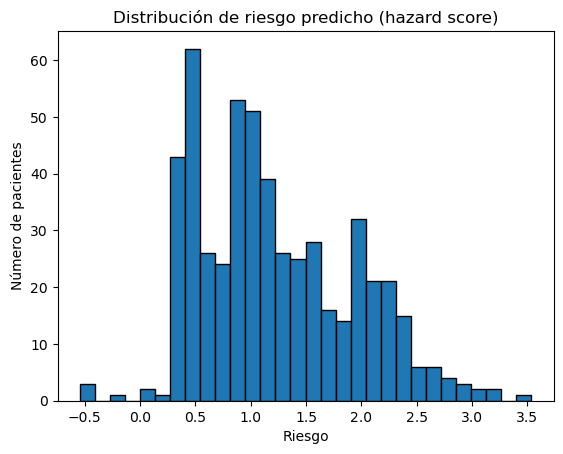

In [6]:
model.eval()
with torch.no_grad():
    risk_scores = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()

import matplotlib.pyplot as plt
plt.hist(risk_scores, bins=30, edgecolor='k')
plt.title('Distribución de riesgo predicho (hazard score)')
plt.xlabel('Riesgo')
plt.ylabel('Número de pacientes')
plt.show()


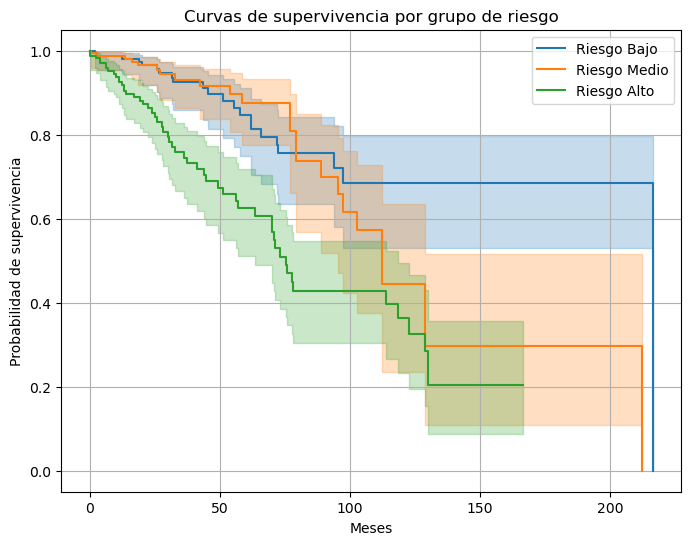

In [7]:
# Crear DataFrame para agrupar
df_pred = pd.DataFrame({
    'time': y_test_time,
    'event': y_test_event,
    'risk': risk_scores
})

# Dividir en terciles
df_pred['risk_group'] = pd.qcut(df_pred['risk'], q=3, labels=["Bajo", "Medio", "Alto"])

# Graficar curvas de supervivencia
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))
for group in df_pred['risk_group'].unique():
    mask = df_pred['risk_group'] == group
    kmf.fit(df_pred.loc[mask, 'time'], df_pred.loc[mask, 'event'], label=f'Riesgo {group}')
    kmf.plot_survival_function()

plt.title("Curvas de supervivencia por grupo de riesgo")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de supervivencia")
plt.grid(True)
plt.show()


In [8]:
# Calculamos el C-index sobre el conjunto de test
c_index = concordance_index(
    y_test_time,             # tiempos de supervivencia
    -risk_scores,            # usamos el negativo porque mayor score = mayor riesgo
    y_test_event             # evento observado (1 = muerte)
)

print(f"Índice de concordancia (C-index): {c_index:.3f}")

Índice de concordancia (C-index): 0.670
